In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import glob
import os

In [2]:
class Feature:
    def __init__(self, keypoint, descriptor):
        self.position = keypoint.pt
        self.angle = keypoint.angle
        self.size = keypoint.size
        self.descriptor = descriptor
        self.joining_vector = None

In [142]:
class Accumulator:
    def __init__(self, image_shape, scale_factor=10):
        self.scale_factor = scale_factor
        self.accumulator_size = (
            int(image_shape[0] / scale_factor),
            int(image_shape[1] / scale_factor)
        )
        self.accumulator = np.zeros(self.accumulator_size, dtype=np.float32)  

    def vote(self, predicted_reference_pixel):
        x_scaled = predicted_reference_pixel[0] // self.scale_factor
        y_scaled = predicted_reference_pixel[1] // self.scale_factor

        h, W = self.accumulator_size
        if 0 <= x_scaled < W and 0 <= y_scaled < h:
            self.accumulator[y_scaled, x_scaled] += 1
    
    def get_peak(self):
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(self.accumulator)
        peak_x = max_loc[0] * self.scale_factor
        peak_y = max_loc[1] * self.scale_factor
        return (int(peak_x), int(peak_y)), max_val
    
    def get_peaks_above_threshold(self, threshold_ratio=0.5):
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(self.accumulator)
        threshold = max_val * threshold_ratio
        peaks = np.argwhere(self.accumulator > threshold)

        peaks_original_scale = peaks * self.scale_factor
        return peaks_original_scale
    
    def display_accumulator(self):
        plt.figure(figsize=(10, 8))
        plt.imshow(self.accumulator, cmap='hot')
        plt.colorbar()
        plt.xlabel('X (quantized)')
        plt.ylabel('Y (quantized)')
        plt.show()

In [143]:
class StarModel:
    def __init__(self):
        self.features = []
        self.barycenter = None

    def add_feature(self, feature):
        self.features.append(feature)

    def compute_barycenter(self):
        if not self.features:
            return None
        points = np.array([feature.position for feature in self.features])
        self.barycenter = np.mean(points, axis=0)

    def computing_joining_vector(self):
        if self.barycenter is None:
            return None
        for feature in self.features:
            feature.joining_vector =  self.barycenter - np.array(feature.position)

In [144]:
class SIFT_GHT_Detector:
    def __init__(self):
        self.sift = cv2.SIFT_create()
        self.model = None

    def detect_and_compute(self, image):
        keypoints, descriptors = self.sift.detectAndCompute(image, None)
        features = [Feature(kp, desc) for kp, desc in zip(keypoints, descriptors)]
        return features
    
    def build_model(self, model_image):
        features = self.detect_and_compute(model_image)
        model = StarModel()
        for feature in features:
            model.add_feature(feature)
        model.compute_barycenter()
        model.computing_joining_vector()
        return model
    
    def match_features(self, model, target_features):
        model_descriptors = np.array([feature.descriptor for feature in model.features])
        target_descriptors = np.array([feature.descriptor for feature in target_features])

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(model_descriptors, target_descriptors, k=2)

        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        return good_matches
    
    def apply_scale_rotation(self, joining_vector, scale, rotation):
        scaled_vector = scale * joining_vector

        angle_rad = np.deg2rad(rotation)
        rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)], 
                                    [np.sin(angle_rad), np.cos(angle_rad)]])

        rotated_vector = np.dot(rotation_matrix, scaled_vector)
        return rotated_vector
    
    def vote_for_reference_points(self, model, target_features, good_matches, target_image_shape, scale_factor=4):
        accumulator = Accumulator(target_image_shape[:2], scale_factor)

        for match in good_matches:
            model_idx = match.queryIdx
            target_idx = match.trainIdx

            model_feature = model.features[model_idx]
            target_feature = target_features[target_idx]

            scale_ratio = target_feature.size / model_feature.size
            rotation_diff = (target_feature.angle - model_feature.angle) % 360

            transformed_joining_vector = self.apply_scale_rotation(
                model_feature.joining_vector, scale_ratio, rotation_diff
            )
            predicted_reference_pixel = np.array(target_feature.position) + transformed_joining_vector
            predicted_reference_pixel = np.round(predicted_reference_pixel).astype(np.int32)

            accumulator.vote(predicted_reference_pixel)

        return accumulator
    
    def calculate_homography(self, model_image, good_matches, model, target_features):
        MIN_MATCH_COUNT = 10
        if len(good_matches) > MIN_MATCH_COUNT:
            src_pts = np.float32([model.features[m.queryIdx].position for m in good_matches]).reshape(-1,2)
            dst_pts = np.float32([target_features[m.trainIdx].position for m in good_matches]).reshape(-1,2)

            M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            h, w = model_image.shape[:2]
            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(pts, M)
            return np.int32(dst)
        else:
            print("Not enough matches are found - %d/%d" % (len(good_matches), MIN_MATCH_COUNT))
            return None

    def detect(self, model_image, target_image):
        model = self.build_model(model_image)
        target_features = self.detect_and_compute(target_image)
        good_matches = self.match_features(model, target_features)
        accumulator = self.vote_for_reference_points(model, target_features, good_matches, target_image.shape)
        max_loc, max_val = accumulator.get_peak()
        bounding_box = self.calculate_homography(model_image, good_matches, model, target_features)

        return max_loc, accumulator, bounding_box

In [145]:
def sharpen(img, k, sigma):
    m = (2 * int(3 * sigma) + 1)
    g = cv2.getGaussianKernel(m, sigma)
    F_b = np.outer(g, g)
    F_id = np.zeros((m, m)); 
    F_id[m // 2, m // 2] = 1
    sharpen_filter = F_id + k * (F_id - F_b)
    return cv2.filter2D(img, -1, sharpen_filter)

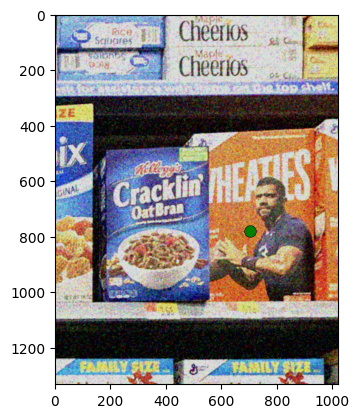

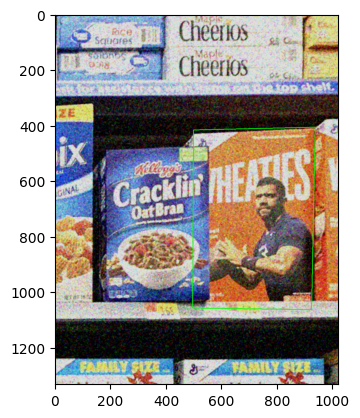

In [140]:
target_images = sorted(glob.glob("./dataset/scenes/trackA/*.png"))
model_images = sorted(glob.glob("./dataset/models/trackA/*.png"))

target_image = cv2.imread(target_images[-1])
model_image = cv2.imread(model_images[3])

# we split the image into 3 channels and apply the median filter to each channel
r, g, b = cv2.split(target_image)
r = cv2.medianBlur(r, 5)
g = cv2.medianBlur(g, 5)
b = cv2.medianBlur(b, 5)
target_image = cv2.merge([r, g, b])
# target_image = cv2.fastNlMeansDenoisingColored(target_image, None, 10, 10, 7, 21)
# target_image = sharpen(target_image, 0.5, 1)

detector = SIFT_GHT_Detector()
detection_point, accumulator, bounding_box = detector.detect(model_image, target_image)

# viusalize detection point on the target image
target_image_with_detection_point = target_image.copy()
plt.scatter(*detection_point, color='black', s=60)
plt.scatter(*detection_point, color='green', s=50)
plt.imshow(target_image_with_detection_point)
plt.imshow(cv2.cvtColor(target_image_with_detection_point, cv2.COLOR_BGR2RGB))
plt.show()

# visualize the bounding box on the target image
target_image_with_bounding_box = target_image.copy()
cv2.polylines(target_image_with_bounding_box, [bounding_box], True, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(target_image_with_bounding_box, cv2.COLOR_BGR2RGB))
plt.show()

In [146]:
def visualize_barycenter(image, model):
    image = image.copy()

    plt.imshow(image)
    plt.scatter(*model.barycenter, color='black', s=60)
    plt.scatter(*model.barycenter, color='red', s=50)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

def visualize_joining_vectors(image, model, num_vectors=3):
    image = image.copy()
    for i in np.random.choice(len(model.features), num_vectors, replace=False):
        start_point = model.features[i].position
        joining_vector = model.features[i].joining_vector
        plt.arrow(start_point[0], start_point[1], joining_vector[0], joining_vector[1], color='red', head_width=10)
        plt.scatter(*start_point, color='yellow', s=60)
        plt.scatter(*start_point, color='blue', s=10)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

def visualize_accumulator(accumulator):
    plt.figure(figsize=(8, 8))
    plt.imshow(accumulator, cmap='hot')
    plt.colorbar()

    for i in range(accumulator.shape[0]):
        for j in range(accumulator.shape[1]):
            value = accumulator[i, j]
            if value > 0:
                plt.text(j, i, f'{value:.0f}', ha='center', va='center', color='white')

def visualize_transformed_vectors():
    pass

def visualize_bounding_box():
    pass

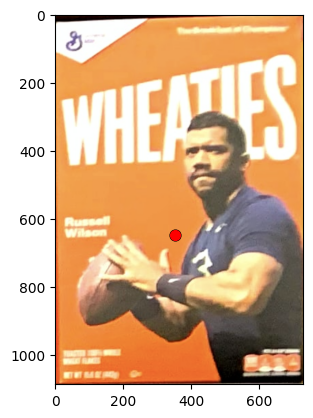

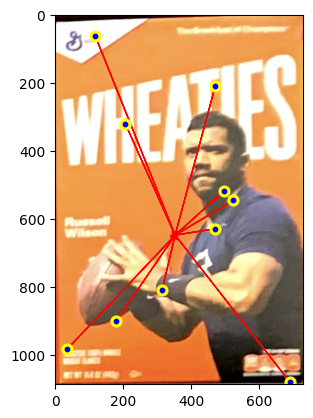

In [150]:
model = detector.build_model(model_image)
visualize_barycenter(model_image, model)
visualize_joining_vectors(model_image, model, num_vectors=10)

In [148]:
# class SIFT_GHT_Detector:
#     def __init__(self):
#         self.sift = cv2.SIFT_create()
#         self.model = None

#     def detect_and_compute(self, image):
#         keypoints, descriptors = self.sift.detectAndCompute(image, None)
#         features = [Feature(kp, desc) for kp, desc in zip(keypoints, descriptors)]
#         return features
    
#     def build_model(self, model_image):
#         features = self.detect_and_compute(model_image)
#         model = StarModel()
#         for feature in features:
#             model.add_feature(feature)
#         model.compute_barycenter()
#         model.computing_joining_vector()
#         return model
    
#     def match_features(self, model, target_features):
#         model_descriptors = np.array([feature.descriptor for feature in model.features])
#         target_descriptors = np.array([feature.descriptor for feature in target_features])

#         FLANN_INDEX_KDTREE = 1
#         index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
#         search_params = dict(checks=50)
#         flann = cv2.FlannBasedMatcher(index_params, search_params)
#         matches = flann.knnMatch(model_descriptors, target_descriptors, k=2)

#         good_matches = []
#         for m, n in matches:
#             if m.distance < 0.75 * n.distance:
#                 good_matches.append(m)
#         return good_matches
    
#     def apply_scale_rotation(self, joining_vector, scale, rotation):
#         scaled_vector = scale * joining_vector

#         angle_rad = np.deg2rad(rotation)
#         rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)], [np.sin(angle_rad), np.cos(angle_rad)]])

#         rotated_vector = np.dot(rotation_matrix, scaled_vector)
#         return rotated_vector
    
#     def vote_for_reference_points(self, model, target_features, good_matches, target_image_shape):
#         accumulator = np.zeros(target_image_shape[:2], dtype=np.float32)

#         for match in good_matches:
#             model_idx = match.queryIdx
#             target_idx = match.trainIdx

#             model_feature = model.features[model_idx]
#             target_feature = target_features[target_idx]

#             scale_ratio = target_feature.size / model_feature.size
#             rotation_diff = target_feature.angle - model_feature.angle

#             transformed_joining_vector = self.apply_scale_rotation(model_feature, model_feature.joining_vector, scale_ratio, rotation_diff)

#             predicted_reference_point = np.array(target_feature.position) + transformed_joining_vector
#             predicted_reference_point = tuple(np.round(predicted_reference_point).astype(int))

#             if 0 <= predicted_reference_point[0] < accumulator.shape[1] and 0 <= predicted_reference_point[1] < accumulator.shape[0]:
#                 accumulator[predicted_reference_point[1], predicted_reference_point[0]] += 1

#         return accumulator
    
#     def cluster_votes(self, votes, eps=20, min_samples=3):
#         vote_positions = np.array([vote[0] for vote in votes])
#         clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(vote_positions)

#         clusters = {}
#         for idx, label in enumerate(clustering.labels_):
#             if label != -1:
#                 continue
#             if label not in clusters:
#                 clusters[label] = []
#             clusters[label].append(votes[idx][1])
#         return clusters
    
#     def calculate_homography(self, model_image, target_image, matches, model, target_features):
#         src_pts = np.float32([model.features[m.queryIdx].position for m in matches]).reshape(-1,2)
#         dst_pts = np.float32([target_features[m.trainIdx].position for m in matches]).reshape(-1,2)

#         if len(src_pts) >= 10:
#             M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
#             if M is not None:
#                 h, w = model_image.shape[:2]
#                 pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
#                 dst = cv2.perspectiveTransform(pts, M)
#                 return np.int32(dst)
#         return None

#     def detect(self, model_image, target_image, threshold=10):
#         model = self.build_model(model_image)
#         target_features = self.detect_and_compute(target_image)
#         good_matches = self.match_features(model, target_features)
        
#         accumulator = self.vote_for_reference_points(model, target_features, good_matches, target_image.shape)
#         clusters = self.cluster_votes(accumulator)
    
#         bounding_boxes = []
#         for _, cluster_matches in clusters.items():
#             if len(cluster_matches) < 10:
#                 continue
#             bounding_box = self.calculate_homography(model_image, target_image, cluster_matches, model, target_features)
#             if bounding_box is not None:
#                 points = bounding_box.reshape(-1, 2)
#                 xs = points[:, 0]
#                 ys = points[:, 1]
#                 x_min, x_max = xs.min(), xs.max()
#                 y_min, y_max = ys.min(), ys.max()
#                 width = x_max - x_min
#                 height = y_max - y_min
#                 x_center = x_min + width / 2
#                 y_center = y_min + height / 2

#                 bounding_boxes.append({
#                     "position": (float(x_center), float(y_center)),
#                     "width": width,
#                     "height": height
#                 })
       
#         return bounding_boxes

In [17]:
# def generate_output(results, target_image, show_bounding_boxes=False, show_label=False):
#     target_image_copy = target_image.copy()

#     for product_id, result in results.items():
#         print("Product", product_id, "-", result["instances_found"], "instance(s) found:")

#         for i, bbox in enumerate(result["bounding_boxes"], 1):
#             print(f"Instance {i}: position: {bbox['position']}, width: {bbox['width']}px, height: {bbox['height']}px")

#         if show_bounding_boxes:
#             pt = bbox['position']
#             w = bbox['width']
#             h = bbox['height']

#             tl = int(pt[0] - w/2), int(pt[1] - h/2)
#             br = int(pt[0] + w/2), int(pt[1] + h/2)
#             cv2.rectangle(target_image_copy, tl, br, (0, 255, 0), 2)

#             if show_label:
#                 font_scale = w / 80
#                 thickness = int(w / 50)
#                 test_size, _ = cv2.getTextSize(product_id, 
#                                                cv2.FONT_HERSHEY_SIMPLEX, 
#                                                font_scale, 
#                                                thickness)
                
#                 # text_x = pt[0] - test_size[0] // 2
#                 text_y = pt[1] + test_size[1] // 2 

#                 cv2.putText(target_image_copy, 
#                             product_id, 
#                             (text_x, text_y),
#                             cv2.FONT_HERSHEY_SIMPLEX, 
#                             font_scale, 
#                             (0, 255, 0), 
#                             thickness)

#     if show_bounding_boxes:
#         plt.imshow(cv2.cvtColor(target_image_copy, cv2.COLOR_BGR2RGB))
#         plt.show()

In [ ]:
# detector = SIFT_GHT_Detector()

# target_images = sorted(glob.glob("./dataset/scenes/trackA/*.png"))
# model_images = sorted(glob.glob("./dataset/models/trackA/*.png"))

# for scene_name, scene_img in preprocessed_scenes.items():
#     print(f"Processing {scene_name}")
#     results = {}

#     for model_image_path in model_images:
#         product_id = os.path.splitext(os.path.basename(model_image_path))[0]
#         model_image = cv2.imread(model_image_path)
#         bounding_boxes = detector.detect(model_image, scene_img, threshold=5)

#         results[product_id] = {
#             "instances_found": len(bounding_boxes),
#             "bounding_boxes": bounding_boxes
#         }

#     generate_output(results, scene_img, show_bounding_boxes=False, show_label=False)